# Early Organogenesis Dataset

Here, we separate the early organogenesis cell atlas in ["A single-cell molecule map of mouse gastrulation and early organogenesis"](https://www.nature.com/articles/s41586-019-0933-9#Abs1) by cell stage (E6.5-E8.5), so we can analyze pathway states for each time point separately.

In [1]:
import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb

import module as md

# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
datadir = '../../data/raw_data/sc_data/early_organogenesis/'
resdir = '../../data/processed_data/sc_data/early_organogenesis/'

## Data Pre-Processing <a class="anchor" id="1-bullet"></a>

In [2]:
adata = sc.read(datadir+"matrix.mtx",cache=True).T

adata.obs.index = pd.read_csv(datadir+"barcodes.tsv", delimiter="\t")["barcode"]
adata.var.index = pd.read_csv(datadir+"genes.tsv", delimiter="\t")["gene"]

adata

AnnData object with n_obs × n_vars = 139331 × 29452

In [3]:
meta = pd.read_csv(datadir+"meta.csv")
meta = meta.set_index(meta["barcode"])
meta = meta.drop("barcode", axis=1)

adata.obs["stage"] = meta["stage"]
adata.obs["batch"] = meta["sequencing.batch"]
adata.obs["batch"] = [str(i) for i in adata.obs["batch"]]
adata.obs["cell_type"] = meta["celltype"]

adata.obs_names_make_unique()
adata.var_names_make_unique()
adata = adata[~adata.obs["cell_type"].isna()]

meta.head()

/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,cell,sample,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,...,haem_gephiY,haem_subclust,endo_gephiX,endo_gephiY,endo_trajectoryName,endo_trajectoryDPT,endo_gutX,endo_gutY,endo_gutDPT,endo_gutCluster
barcode,,,,,,,,,,,,,,,,,,,,,
AAAGGCCTCCACAA,cell_1,1,E6.5,1,TS9,0.043114,False,2.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACAAACTCGCCTT,cell_2,1,E6.5,1,TS9,1.129713,False,12.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACAATACCCGTAA,cell_3,1,E6.5,1,TS9,0.000000,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACACTCTCATTCT,cell_4,1,E6.5,1,TS9,0.084689,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACAGAGAATCAGC,cell_5,1,E6.5,1,TS9,0.112121,False,3.0,7.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Before Processing <a class="anchor" id="2-bullet"></a>

Trying to set attribute `.obs` of view, copying.
/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'stage' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical


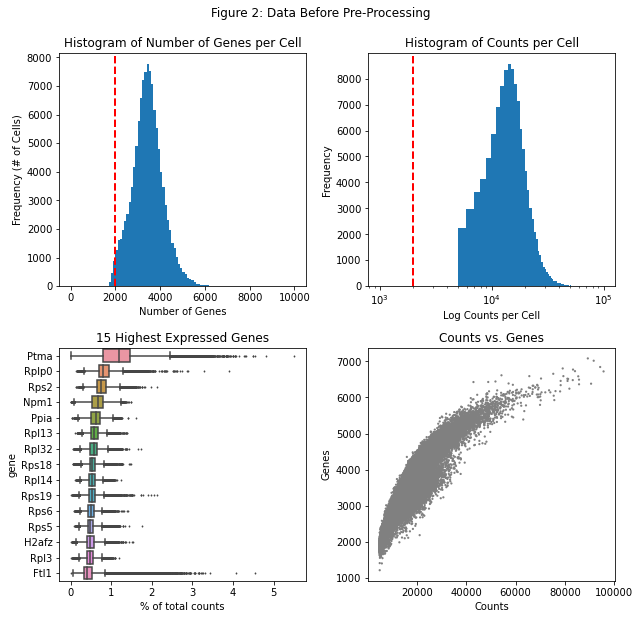

CPU times: user 35.2 s, sys: 58.1 s, total: 1min 33s
Wall time: 1min 54s


In [4]:
%%time

# Below, we display cells with genes/cell and counts/cell, for genes that 
# have at least one 1 count in any cell. 
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Set annotations to the AnnData object for total counts, cells per gene, and mitochondrial genes
adata.obs['n_total_counts_per_cell'] = (adata.X.sum(axis=1).A1)
adata.var['n_cells_per_gene'] = adata.X.astype(bool).astype(int).sum(axis=0).A1
adata.obs['n_genes_per_cell'] = adata.X.astype(bool).astype(int).sum(axis=1).A1

# This line of code makes a plot with the different plots on the data
# prior to processing it. 
pre_processed = md.vis_pre_processing(adata, genes_range=(0, 10000),
    counts_range=(1e3, 1e5),title='Figure 2: Data Before Pre-Processing',
                                     genes_threshold = 2000, counts_threshold=2000)

In [5]:
# Create separate AnnData objects for each time point.
adatas = [adata[adata.obs['stage'] == i] for i in list(adata.obs['stage'].unique())]

/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
stages = [list(i.obs['stage'].unique())[0] for i in adatas]
avg_genes = [int(np.average(i.obs['n_genes_per_cell'])) for i in adatas]
avg_counts = [int(np.average(i.obs['n_total_counts_per_cell'])) for i in adatas]

for i in range(0,len(adatas)):
    text = "Stage {} has {} average genes/cell and {} average total counts per cell."
    print(text.format(stages[i], avg_genes[i], avg_counts[i]))

Stage E6.5 has 2977 average genes/cell and 13785 average total counts per cell.
Stage E7.5 has 3546 average genes/cell and 17244 average total counts per cell.
Stage E6.75 has 2796 average genes/cell and 11111 average total counts per cell.
Stage E7.75 has 3616 average genes/cell and 17590 average total counts per cell.
Stage E7.0 has 3456 average genes/cell and 16389 average total counts per cell.
Stage E8.0 has 3368 average genes/cell and 14718 average total counts per cell.
Stage E8.5 has 3494 average genes/cell and 17134 average total counts per cell.
Stage mixed_gastrulation has 3743 average genes/cell and 16720 average total counts per cell.
Stage E7.25 has 3261 average genes/cell and 15181 average total counts per cell.
Stage E8.25 has 3436 average genes/cell and 15705 average total counts per cell.


In [7]:
# Save the AnnData object for each time point.
save_adata = [adatas[i].write_h5ad(resdir+stages[i]+"_post_filtered.h5ad") for i in range(0,len(adatas))]

In [8]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,panel,scanpy,anndata2ri,rpy2,jupyterlab

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.17.0

numpy     : 1.18.5
pandas    : 1.1.0
scipy     : 1.5.2
seaborn   : 0.10.1
matplotlib: 3.2.2
panel     : 0.9.7
scanpy    : 1.5.1
anndata2ri: 0.0.0
rpy2      : 3.3.2
jupyterlab: 2.2.4

